In [1]:
from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
datadir = 'history/2020-02-03T000055Z'
ts = mu.quickts(); print('starting,', ts)

workdir = f'history/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')
os.listdir(workdir)

starting, 2020-02-09T010715Z
Made new workdir, history/2020-02-09T010715Z


[]

In [4]:
lstm_params = [{
    'units': 64,
    'dropout': 0.5,
    'recurrent_dropout': 0.5,
    'batch_input_shape': (None, 64, 8),
    'kernel_initializer': tf.initializers.glorot_normal() # GlorotNormal()
                           #tf.initializers.he_normal()
    },]

optimizer_params = {
    'learning_rate': 0.001,  
    'beta1': 0.9, 
    'beta2': 0.999, 
    'epsilon': 1e-08
}

def bake_model(lstm_params):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [6]:
BATCH_SIZE = 32
EPOCHS = 4
#
print('datadir', datadir, 'workdir', workdir)
train_shuff_loc = f'{datadir}/train_scaled_balanced_shuffled.h5'

X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')
size = X.shape[0]

# save base unfitted model.
model = bake_model(lstm_params)
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')

datadir history/2020-02-03T000055Z workdir history/2020-02-09T010715Z


In [7]:
%%time
modelloc = f'{workdir}/00000__unfitted_model.h5'
print(f'Start train with {modelloc}')
model = mu.load_model(modelloc)

class_weights = {0: 1., 1: 0., 2: 0., 3: 0.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
mu.do_train(
        model,
        dataset_batches,
        k=size,
        num_epochs=EPOCHS,
        optimizer_params=optimizer_params,
        saveloc=workdir)


Start train with history/2020-02-09T010715Z/00000__unfitted_model.h5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




CPU times: user 46min 33s, sys: 3.1 s, total: 46min 36s
Wall time: 46min 33s


### Validation

In [8]:
test_loc = f'{datadir}/test_balanced.h5'
print('test_loc', mu.h5_keys(test_loc))

test_loc ['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [9]:

modelnames_vec = []
for epoch in range(EPOCHS):
    for batch in list(np.arange(200, 1760, 200)) + [1760]:
        step = batch
        prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                               f'_batch_{str(batch).zfill(5)}')

        modelname = f'{prefix}_model.h5'
        print(modelname, os.path.exists(modelname))
        modelnames_vec.append(prefix)
print('modelnames_vec', modelnames_vec)

history/2020-02-09T010715Z/epoch_000_batch_00200_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_00400_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_00600_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_00800_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_01000_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_01200_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_01400_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_01600_model.h5 True
history/2020-02-09T010715Z/epoch_000_batch_01760_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_00200_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_00400_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_00600_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_00800_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_01000_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_01200_model.h5 True
history/2020-02-09T010715Z/epoch_001_batch_01400_model.

In [ ]:
print('starting validation', mu.quickts())
batch_losses_vec = []
print('test_loc', test_loc)
epoch = 0
for step, prefix in enumerate(tqdm(modelnames_vec)):
    # prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
    #                        f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        

  0%|          | 0/36 [00:00<?, ?it/s]

starting validation 2020-02-09T015930Z
test_loc history/2020-02-03T000055Z/test_balanced.h5
history/2020-02-09T010715Z/epoch_000_batch_00200_model.h5 True


  3%|▎         | 1/36 [04:46<2:47:19, 286.83s/it]

history/2020-02-09T010715Z/epoch_000_batch_00400_model.h5 True


  6%|▌         | 2/36 [09:31<2:42:07, 286.09s/it]

history/2020-02-09T010715Z/epoch_000_batch_00600_model.h5 True


  8%|▊         | 3/36 [14:17<2:37:22, 286.15s/it]

history/2020-02-09T010715Z/epoch_000_batch_00800_model.h5 True


 11%|█         | 4/36 [19:03<2:32:32, 286.03s/it]

history/2020-02-09T010715Z/epoch_000_batch_01000_model.h5 True


 14%|█▍        | 5/36 [23:49<2:27:53, 286.23s/it]

history/2020-02-09T010715Z/epoch_000_batch_01200_model.h5 True


 17%|█▋        | 6/36 [28:39<2:23:40, 287.35s/it]

history/2020-02-09T010715Z/epoch_000_batch_01400_model.h5 True


 19%|█▉        | 7/36 [33:26<2:18:44, 287.06s/it]

history/2020-02-09T010715Z/epoch_000_batch_01600_model.h5 True


 22%|██▏       | 8/36 [38:13<2:14:00, 287.15s/it]

history/2020-02-09T010715Z/epoch_000_batch_01760_model.h5 True


 25%|██▌       | 9/36 [43:00<2:09:11, 287.08s/it]

history/2020-02-09T010715Z/epoch_001_batch_00200_model.h5 True


 28%|██▊       | 10/36 [47:45<2:04:05, 286.38s/it]

history/2020-02-09T010715Z/epoch_001_batch_00400_model.h5 True


 31%|███       | 11/36 [52:30<1:59:08, 285.94s/it]

history/2020-02-09T010715Z/epoch_001_batch_00600_model.h5 True


 33%|███▎      | 12/36 [57:15<1:54:17, 285.71s/it]

history/2020-02-09T010715Z/epoch_001_batch_00800_model.h5 True


 36%|███▌      | 13/36 [1:02:02<1:49:41, 286.16s/it]

history/2020-02-09T010715Z/epoch_001_batch_01000_model.h5 True


 39%|███▉      | 14/36 [1:06:47<1:44:45, 285.69s/it]

history/2020-02-09T010715Z/epoch_001_batch_01200_model.h5 True


 42%|████▏     | 15/36 [1:11:33<1:40:06, 286.00s/it]

history/2020-02-09T010715Z/epoch_001_batch_01400_model.h5 True


 44%|████▍     | 16/36 [1:16:28<1:36:13, 288.68s/it]

history/2020-02-09T010715Z/epoch_001_batch_01600_model.h5 True


 47%|████▋     | 17/36 [1:21:13<1:31:01, 287.45s/it]

history/2020-02-09T010715Z/epoch_001_batch_01760_model.h5 True


 50%|█████     | 18/36 [1:25:59<1:26:06, 287.03s/it]

history/2020-02-09T010715Z/epoch_002_batch_00200_model.h5 True


 53%|█████▎    | 19/36 [1:30:43<1:21:04, 286.15s/it]

history/2020-02-09T010715Z/epoch_002_batch_00400_model.h5 True


 56%|█████▌    | 20/36 [1:35:26<1:16:04, 285.27s/it]

history/2020-02-09T010715Z/epoch_002_batch_00600_model.h5 True


 58%|█████▊    | 21/36 [1:40:14<1:11:29, 285.98s/it]

history/2020-02-09T010715Z/epoch_002_batch_00800_model.h5 True


 61%|██████    | 22/36 [1:45:02<1:06:50, 286.47s/it]

history/2020-02-09T010715Z/epoch_002_batch_01000_model.h5 True


In [14]:
meanlossesarr

array([1.2484009 , 1.23448573, 1.19409977, 1.16453309, 1.17931211,
       1.18497714, 1.22411191, 1.22398704, 1.24850054, 1.31103911,
       1.33118664, 1.38083243, 1.35652892, 1.4309701 , 1.41161321,
       1.40992384, 1.43772973, 1.4577726 , 1.60686302, 1.70862387,
       1.6175383 , 1.63973585, 1.6164977 , 1.6006812 , 1.70122978,
       1.69351995, 1.70193529, 1.71464974, 1.77576904, 1.85943067,
       1.90501527, 1.82791053, 1.88926429, 2.02341145, 1.83123823,
       1.93111178])

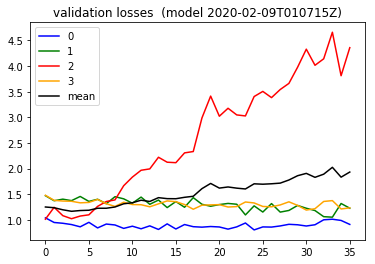

In [15]:
plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()    